# **FLOW**

1. 연속형 변수(Income_total, Days_employed, Begin_month, Days_Birth) Minmax Scaling 적용
- Income_total : 4분위수에 근거하여 Outlier 를 Q1, Q3로 대체하였습니다.
- Days_employed : 실직을 뜻하는 양수 값은 0으로 대체하고 나머지 음수 값은 절대값을 취하여 양수로 전환하였습니다.
- Begin_month : 동일 인물로 추정되는 데이터 중 Begin_month 까지 동일한 데이터는 한개씩만 남겨두었습니다.
- Days_Birth : 절대값 /365를 나누고 int로 전환하여 나이를 의미하도록 만들었습니다.

2. 범주형 변수 PART.1(income_type, house_type, edu_type, family_type, occyp_type)

3. 범주형 변수 PART.2(Family_size, Child_num) 두 컬럼은 경향성이 존재하기 때문에 Ordinal Encoding을 적용했습니다.

4. Binary 변수(Gender, Car, Reality, Phone, Work_phone, Email, FLAG_MOBIL)

3. 파생 변수 


In [535]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  float64
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int32  
 11  DAYS_EMPLOYED  26457 non-null  float64
 12  FLAG_MOBIL     26457 non-null  object 
 13  work_phone     26457 non-null  object 
 14  phone          26457 non-null  object 
 15  email          26457 non-null  object 
 16  occyp_type     26457 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [323]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
  
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, plot_confusion_matrix
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from sklearn.pipeline import make_pipeline
from tqdm import tqdm

In [468]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
submission = pd.read_csv('../Data/sample_submission.csv')
sub_train = train

# **동월 카드를 2회 이상 발급한 경우 처리**

In [464]:
train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) + str(n)  for i,j,k,l,m,n in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'], train['begin_month'])]
test['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) + str(n) for i,j,k,l,m,n in zip(test['gender'],test['income_total'],test['income_type'],test['DAYS_BIRTH'],test['DAYS_EMPLOYED'],test['begin_month'])]

print(f"train set 중복데이터가 아닌 사람의 수 : {sum(train['identity'].value_counts()==1)}명")
print(f"test set 중복데이터가 아닌 사람의 수 : {sum(test['identity'].value_counts()==1)}명")
print('-'*60)
print(f"train set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(train['identity'].value_counts()>=2)}명")
print(f"test set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(test['identity'].value_counts()>=2)}명")

train set 중복데이터가 아닌 사람의 수 : 21948명
test set 중복데이터가 아닌 사람의 수 : 9303명
------------------------------------------------------------
train set 동일인물의 중복데이터로 추정되는 사람의 수 : 2150명
test set 동일인물의 중복데이터로 추정되는 사람의 수 : 344명


In [465]:
subset = train['identity'].value_counts() > 1
subset

F135000.0Pensioner-20752365243-23.0               True
F315000.0Working-13064-2286-33.0                  True
F112500.0Working-13686-1256-2.0                   True
M148500.0Working-11819-962-3.0                    True
M216000.0Commercial associate-19150-7415-18.0     True
                                                 ...  
F90000.0Pensioner-23478365243-14.0               False
M202500.0Working-18281-3596-7.0                  False
F180000.0State servant-15972-5055-13.0           False
F157500.0Working-19176-2959-31.0                 False
F135000.0Pensioner-22504365243-3.0               False
Name: identity, Length: 24098, dtype: bool

In [466]:
drop_list = []

for i in range(len(subset)):
    if subset.values[i] == True:
        drop_list.append(subset.index[i])
    else:
        pass

In [467]:
for i in tqdm(range(len(drop_list))):
    train = train.drop(index = train.loc[train['identity'] == drop_list[i]].sort_values(by=['begin_month']).index[1:] , axis=0)

 54%|█████▍    | 1170/2150 [00:11<00:09, 98.19it/s] 


KeyboardInterrupt: 

In [469]:
print(train.shape, "기존 dataframe의 shape는 (26457, 21) 였습니다.")

(26457, 20) 기존 dataframe의 shape는 (26457, 21) 였습니다.


In [470]:
train = train.drop('identity', axis = 1)
test = test.drop('identity', axis = 1)

KeyError: "['identity'] not found in axis"

# **Preprocessing**

In [471]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

## **0. FLAG_MOBIL**

In [472]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'] - train['work_phone']*0.3 - train['phone']*0.3 - train['email']*0.3
test['FLAG_MOBIL'] = test['FLAG_MOBIL'] - test['work_phone']*0.3 - test['phone']*0.3 - test['email']*0.3

In [473]:
train['FLAG_MOBIL'].value_counts()

1.0    14542
0.7     7962
0.4     3675
0.1      278
Name: FLAG_MOBIL, dtype: int64

In [474]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])
test['FLAG_MOBIL'] = test['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])

## **1. DAYS_EMPLOYED**

In [475]:
train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()

365243    4438
Name: DAYS_EMPLOYED, dtype: int64

In [476]:
train.loc[train['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0

<AxesSubplot:ylabel='Frequency'>

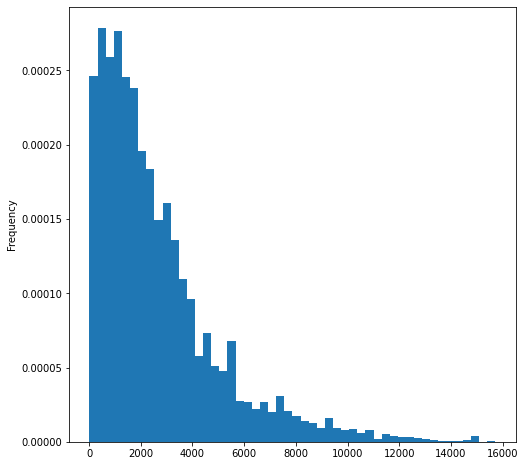

In [477]:
abs(train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED']).plot(kind='hist',bins=50,density=True)

In [478]:
train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
train['DAYS_EMPLOYED']

0        4709
1        1540
2        4434
3        2092
4        2105
         ... 
26452    1984
26453    2475
26454    2015
26455     107
26456    1013
Name: DAYS_EMPLOYED, Length: 26457, dtype: int64

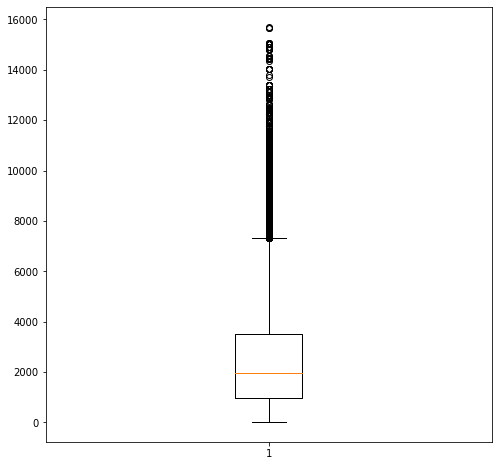

In [479]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [480]:
Q1 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.25))
Q2 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.50))
Q3 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.75))
IQR = Q3 - Q1

print(f'Q1 : {Q1} Q3 : {Q3} IQR : {IQR}')

Q1 : 969.5 Q3 : 3506.0 IQR : 2536.5


In [481]:
train.loc[(train['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (train['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3
test.loc[(test['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (test['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3

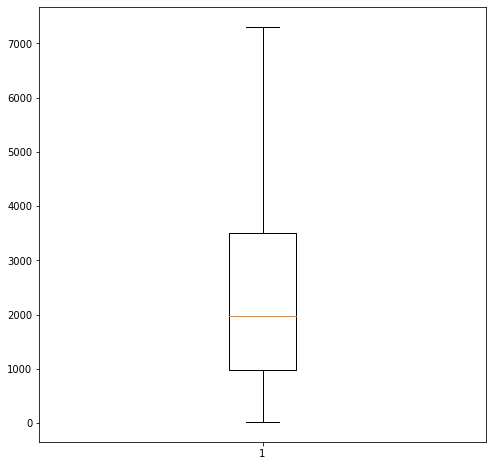

In [482]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [483]:
""" train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED']*100
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED']*100 """

" train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED']*100\ntest['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED']*100 "

In [484]:
train['DAYS_EMPLOYED'].value_counts()

0.0       4438
3506.0    1263
401.0       57
1539.0      47
200.0       45
          ... 
549.0        1
5404.0       1
2160.0       1
738.0        1
3189.0       1
Name: DAYS_EMPLOYED, Length: 3122, dtype: int64

## **2. BEGIN_MONTH**

<AxesSubplot:ylabel='Frequency'>

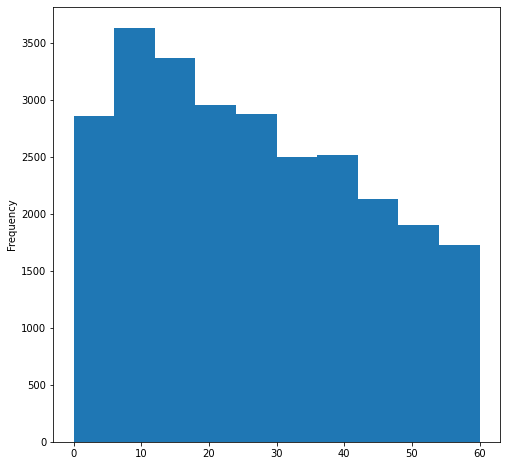

In [485]:
abs(train['begin_month']).plot(kind='hist', bins = 10)

In [486]:
train['begin_month'] = train['begin_month'].abs()
test['begin_month'] = test['begin_month'].abs()

In [487]:
train['begin_month'].value_counts()

7.0     662
11.0    617
8.0     612
3.0     593
6.0     591
       ... 
58.0    244
59.0    242
60.0    235
0.0     231
57.0    228
Name: begin_month, Length: 61, dtype: int64

## **3. INCOME_TOTAL**

<AxesSubplot:ylabel='Frequency'>

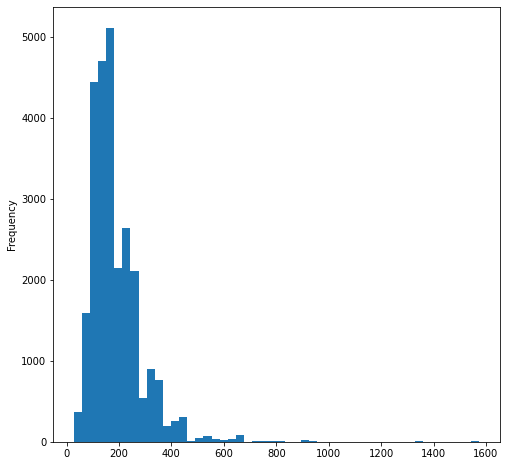

In [488]:
(train['income_total']/1000).plot(kind = 'hist', bins = 50)

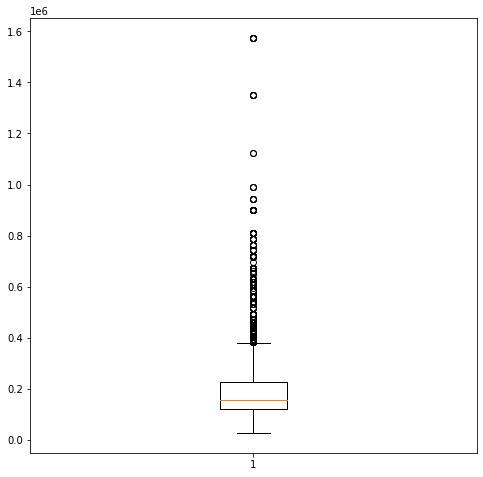

In [489]:
plt.boxplot(train['income_total'])
plt.show()

In [490]:
def box_value(col):
    Q1 = abs(train[train[col] > 0][col].quantile(0.25))
    Q2 = abs(train[train[col] > 0][col].quantile(0.50))
    Q3 = abs(train[train[col] > 0][col].quantile(0.75))
    IQR = Q3 - Q1

    return Q1, Q2, Q3, IQR

In [491]:
Q1 = box_value('income_total')[0]
Q2 = box_value('income_total')[1]
Q3 = box_value('income_total')[2]
IQR = box_value('income_total')[3]

In [492]:
train.loc[(train['income_total'] <= Q1 - 1.5 * IQR) | (train['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3
test.loc[(test['income_total'] <= Q1 - 1.5 * IQR) | (test['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3

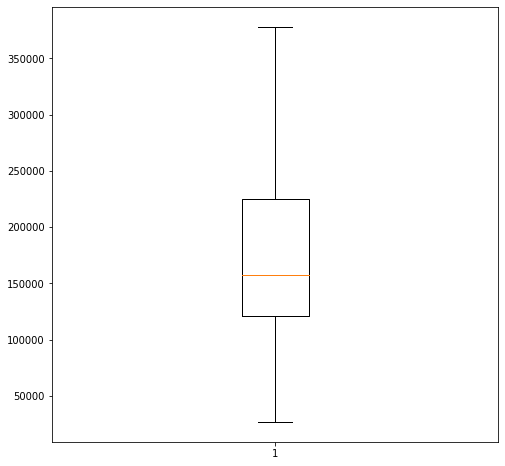

In [493]:
plt.boxplot(train['income_total'])
plt.show()

## **4. Gender**, **Car**, **Reality**

In [494]:
""" train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------') """

" train['gender'] = train['gender'].replace(['F','M'],[0,1])\ntest['gender'] = test['gender'].replace(['F','M'],[0,1])\nprint('gender :')\nprint(train['gender'].value_counts())\nprint('--------------')\n\nprint('Having a car or not : ')\ntrain['car'] = train['car'].replace(['N','Y'],[0,1])\ntest['car'] = test['car'].replace(['N','Y'],[0,1])\nprint(train['car'].value_counts())\nprint('--------------')\n\nprint('Having house reality or not: ')\ntrain['reality'] = train['reality'].replace(['N','Y'],[0,1])\ntest['reality'] = test['reality'].replace(['N','Y'],[0,1])\nprint(train['reality'].value_counts())\nprint('--------------') "

## **5. DAYS_BIRTH**

In [495]:
train['DAYS_BIRTH'] = (train['DAYS_BIRTH'].abs()/365).astype(int)
test['DAYS_BIRTH'] = (test['DAYS_BIRTH'].abs()/365).astype(int)

<AxesSubplot:ylabel='Frequency'>

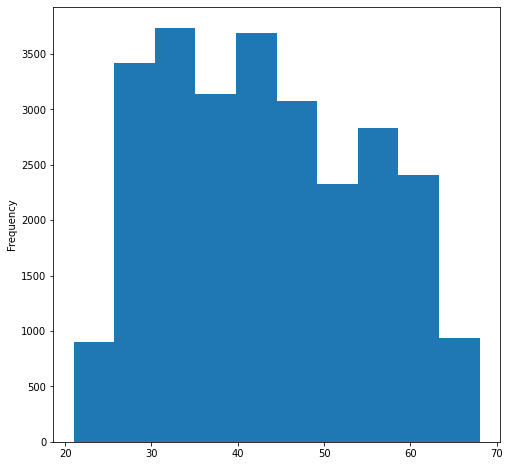

In [496]:
train['DAYS_BIRTH'].plot(kind='hist')

In [497]:
train['DAYS_BIRTH'].value_counts()

37    903
27    836
40    820
28    809
34    796
39    795
32    772
33    753
41    750
38    749
42    733
35    724
43    717
30    716
31    691
36    686
46    674
29    671
44    671
47    654
48    631
51    625
54    619
57    611
50    593
59    587
56    586
60    584
45    577
53    564
58    554
49    542
52    539
55    461
62    454
63    396
61    389
26    388
64    386
25    358
24    271
65    240
66    199
23    159
22    109
67     85
68     23
21      7
Name: DAYS_BIRTH, dtype: int64

## **6. family_size**

In [498]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [499]:
test['family_size'].value_counts()

2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64

In [500]:
train['family_size'] = train['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)
test['family_size'] = test['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)

In [501]:
train['family_size'] = train['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})
test['family_size'] = test['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})

In [502]:
train['family_size'].value_counts()

B    14106
A     5109
C     4632
D     2610
Name: family_size, dtype: int64

## **7. work_phone**, **phone**, **email**, **FLAG_MOBIL**

In [503]:
train['work_phone'] = train['work_phone'].replace([0,1], ['N','Y'])
test['work_phone'] = test['work_phone'].replace([0,1], ['N','Y'])

train['phone'] = train['phone'].replace([0,1], ['N','Y'])
test['phone'] = test['phone'].replace([0,1], ['N','Y'])

train['email'] = train['email'].replace([0,1], ['N','Y'])
test['email'] = test['email'].replace([0,1], ['N','Y'])

## **8. CHILD_NUM & INCOME_CHILD(파생변수)**

In [504]:
train.loc[train['child_num'] > 3, 'child_num'] = 3
test.loc[test['child_num'] > 3, 'child_num'] = 3

In [505]:
""" train['income_child'] = train['income_total']/(train['child_num']+ 0.000001)
test['income_child'] = test['income_total']/(test['child_num'] + 0.000001) """

" train['income_child'] = train['income_total']/(train['child_num']+ 0.000001)\ntest['income_child'] = test['income_total']/(test['child_num'] + 0.000001) "

In [506]:
def child_category(value):
    ep = ''
    if value == 0: ep = 'A'
    elif value == 1: ep = 'B'
    elif value == 2: ep = 'C'
    elif value >= 3: ep = 'D'
    
    return ep

In [507]:
train['child_num'] = train['child_num'].apply(lambda x : child_category(x))
test['child_num'] = test['child_num'].apply(lambda x : child_category(x))

In [508]:
train['child_num'].value_counts()

A    18340
B     5386
C     2362
D      369
Name: child_num, dtype: int64

## **9. OCCYP_TYPE**

In [509]:
def box_category(value):
    ep = ''
    if value <= Q1: ep = 0
    elif value <= Q2: ep = 1
    elif value <= Q3: ep = 2
    elif value > Q3: ep = 3
       
    return ep

train['income_box'] = train['income_total'].apply(lambda x : box_category(x))
test['income_box'] = test['income_total'].apply(lambda x : box_category(x))

In [510]:
train['occyp_type'] = train['occyp_type'].fillna('Secret')
test['occyp_type'] = test['occyp_type'].fillna('Secret')

subset = pd.crosstab(train['occyp_type'] , train['income_box'])
subset['Total'] = subset.sum(axis=1)

subset = subset.div(subset['Total'].values, axis = 0)
subset = subset.drop('Total', axis = 1)
subset = subset.drop('Secret', axis = 0)

kmeans = KMeans(n_clusters= 3)
kmeans.fit(subset)

KMeans(n_clusters=3)

In [511]:
subset['Cluster'] = kmeans.labels_ 

In [512]:
train['occyp_type'] = train['occyp_type'].replace('Secret' , 'A')
train['occyp_type'] = train['occyp_type'].replace(subset.loc[subset['Cluster'] == 2].index.values.tolist(),'B')
train['occyp_type'] = train['occyp_type'].replace(subset.loc[subset['Cluster'] == 1].index.values.tolist(), 'C')
train['occyp_type'] = train['occyp_type'].replace(subset.loc[subset['Cluster'] == 0].index.values.tolist(), 'D')

In [513]:
test['occyp_type'] = test['occyp_type'].replace('Secret' , 'A')
test['occyp_type'] = test['occyp_type'].replace(subset.loc[subset['Cluster'] == 2].index.values.tolist(),'B')
test['occyp_type'] = test['occyp_type'].replace(subset.loc[subset['Cluster'] == 1].index.values.tolist(), 'C')
test['occyp_type'] = test['occyp_type'].replace(subset.loc[subset['Cluster'] == 0].index.values.tolist(), 'D')

In [514]:
train['occyp_type'].value_counts()

D    13984
A     8171
B     2230
C     2072
Name: occyp_type, dtype: int64

In [515]:
test['occyp_type'].value_counts()

D    5146
A    3152
B     861
C     841
Name: occyp_type, dtype: int64

In [516]:
train = train.drop('income_box', axis = 1)
test = test.drop('income_box', axis = 1)

# **데이터 중간 저장**

In [448]:
""" train.to_csv('../Data/Catdata.csv')
test.to_csv('../Data/Cattest.csv') """


" train.to_csv('../Data/Catdata.csv')\ntest.to_csv('../Data/Cattest.csv') "

In [517]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  object 
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int32  
 11  DAYS_EMPLOYED  26457 non-null  float64
 12  FLAG_MOBIL     26457 non-null  object 
 13  work_phone     26457 non-null  object 
 14  phone          26457 non-null  object 
 15  email          26457 non-null  object 
 16  occyp_type     26457 non-null  object 
 17  family_size    26457 non-null  object 
 18  begin_

# **ENCODING**

## **1. Scaling**

In [518]:
scaler = MinMaxScaler()

train['income_total'] = scaler.fit_transform(train['income_total'].values.reshape(-1,1))
test['income_total'] = scaler.transform(test['income_total'].values.reshape(-1,1))

In [519]:
""" train['income_child'] = scaler.fit_transform(train['income_child'].values.reshape(-1,1))
test['income_child'] = scaler.transform(test['income_child'].values.reshape(-1,1)) """

" train['income_child'] = scaler.fit_transform(train['income_child'].values.reshape(-1,1))\ntest['income_child'] = scaler.transform(test['income_child'].values.reshape(-1,1)) "

## **2. ORDINAL ENCODING**

In [520]:
encoder = OrdinalEncoder()
encoder.fit(train[['child_num','family_size']])

train[['child_num','family_size']] = encoder.transform(train[['child_num','family_size']])
encoder.categories_

[array(['A', 'B', 'C', 'D'], dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object)]

In [521]:
test[['child_num','family_size']] = encoder.transform(test[['child_num','family_size']])
encoder.categories_

[array(['A', 'B', 'C', 'D'], dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object)]

## **3.ONE-HOT ENCODING**

In [522]:
train_x=train.drop(['credit','index'], axis=1)
train_y=train[['credit']]
test_x=test.drop('index', axis =1)

In [523]:
train_x = pd.get_dummies(train_x, drop_first= True)
test_x = pd.get_dummies(test_x, drop_first= True)

In [524]:
print(train_x.shape, test_x.shape, train_y.shape)

(26457, 35) (10000, 35) (26457, 1)


# **MODELING**

In [528]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=11, random_state = 2021)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state = 2021))),
    ('cat', CatBoostClassifier(random_state = 2021, learning_rate = 0.08)),
    ('LGB', LGBMClassifier(random_state = 2021, learning_rate = 0.09, n_estimators = 115)),
    ('XGB', XGBClassifier(random_state = 2021))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 2021)
clf.fit(X_train, y_train).score(X_val, y_val)

0:	learn: 1.0539773	total: 18ms	remaining: 18s
1:	learn: 1.0167436	total: 28.1ms	remaining: 14s
2:	learn: 0.9855384	total: 39.8ms	remaining: 13.2s
3:	learn: 0.9599628	total: 50.4ms	remaining: 12.5s
4:	learn: 0.9382033	total: 76.5ms	remaining: 15.2s
5:	learn: 0.9197232	total: 87.5ms	remaining: 14.5s
6:	learn: 0.9039872	total: 96.9ms	remaining: 13.7s
7:	learn: 0.8907032	total: 108ms	remaining: 13.4s
8:	learn: 0.8789473	total: 119ms	remaining: 13.2s
9:	learn: 0.8690000	total: 129ms	remaining: 12.8s
10:	learn: 0.8603822	total: 153ms	remaining: 13.8s
11:	learn: 0.8533344	total: 163ms	remaining: 13.4s
12:	learn: 0.8468191	total: 184ms	remaining: 14s
13:	learn: 0.8412904	total: 199ms	remaining: 14s
14:	learn: 0.8366598	total: 206ms	remaining: 13.5s
15:	learn: 0.8325716	total: 217ms	remaining: 13.4s
16:	learn: 0.8289968	total: 244ms	remaining: 14.1s
17:	learn: 0.8256082	total: 259ms	remaining: 14.1s
18:	learn: 0.8225292	total: 274ms	remaining: 14.2s
19:	learn: 0.8200602	total: 288ms	remaining:

0.7067271352985639

In [529]:
y_pred = clf.predict_proba(test_x)
y_pred.shape

(10000, 3)

In [530]:
y_val_pred = clf.predict_proba(X_val)

In [531]:
print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_val_pred)}") # log_loss: 0.7391310611191586

log_loss: 0.7391310611191586


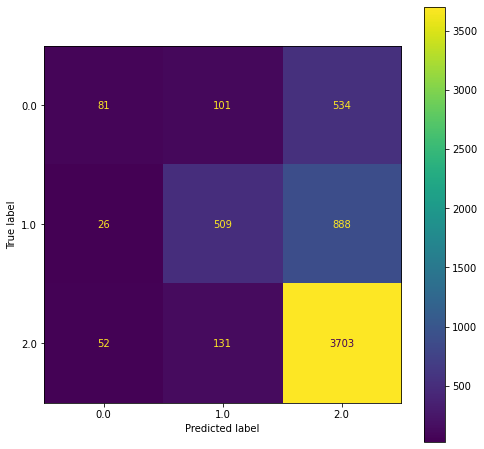

In [462]:
plt.rcParams['figure.figsize'] = (8,8)
plot_confusion_matrix(clf, X_val, y_val)
plt.show()

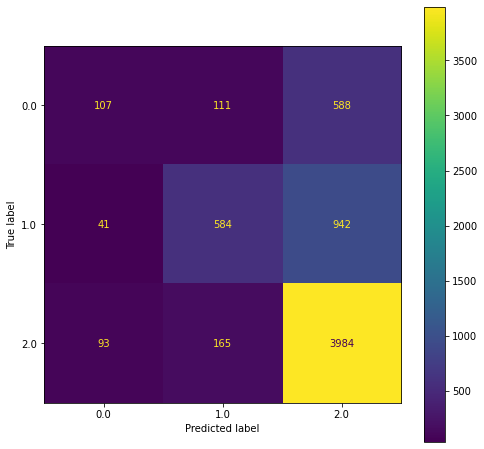

In [532]:
plt.rcParams['figure.figsize'] = (8,8)
plot_confusion_matrix(clf, X_val, y_val)
plt.show()

In [533]:
submission.loc[:,1:] = y_pred

In [534]:
submission

,index,0,1,2
0,26457,0.085752,0.124646,0.789602
1,26458,0.243205,0.176934,0.579861
2,26459,0.072813,0.097115,0.830072
3,26460,0.058355,0.095887,0.845758
4,26461,0.069475,0.121627,0.808898
...,...,...,...,...
9995,36452,0.087180,0.150548,0.762272
9996,36453,0.125703,0.511929,0.362368
9997,36454,0.055758,0.085985,0.858257
9998,36455,0.146538,0.143956,0.709506


In [392]:
submission.to_csv('../Data/LJH_stacking_3.csv', index=False)